In [1]:
import numpy as np
import pygad
import tree_representation
import csv

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best solution ^ x 4.00
Best fitness -3600.1079999999997


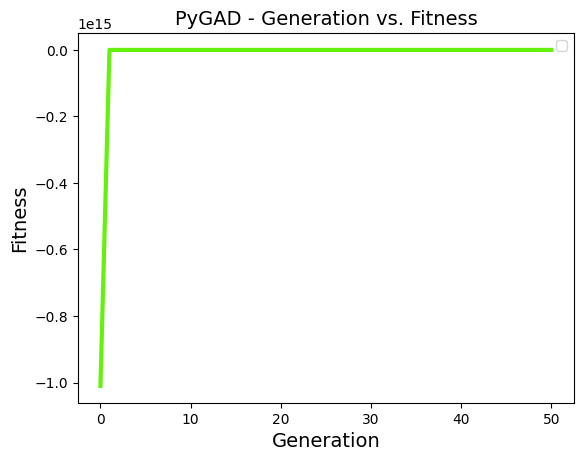

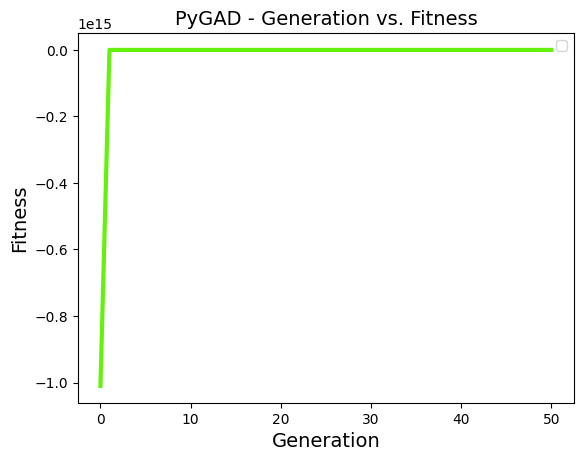

In [24]:
equation_index = 1

with open("dataset.csv") as file:
    reader = csv.reader(file)

    d = 0
    for row in reader:
        xs = np.fromstring(row[1][1:-1], sep=", ")
        ys = np.fromstring(row[2][1:-1], sep=", ")
        if d == equation_index:
           break
        d += 1

def fitness_func(ga_instance, solution, solution_idx):
  tree = tree_representation.fromIntArray(solution)
  fit = tree_representation.fitness(tree, xs, ys)
  return fit


initial_population = [tree_representation.toIntArray(tree_representation.generate_random_tree(0.3)) for _ in range(1000)]


def crossover_func(parents, offspring_size, ga_instance):
  offspring = []
  t1, t2 = tree_representation.fromIntArray(parents[0]), tree_representation.fromIntArray(parents[1])
  
  while len(offspring) != offspring_size[0]:
    child, _ = tree_representation.crossover_tree(t1, t2)

    try:
      offspring.append(tree_representation.toIntArray(child))
    except IndexError:
      print("Not crossovering")
    
  return np.array(offspring)


def mutation_func(offspring, ga_instance):
  new_offspring = []

  for t_numerical in offspring:
    t = tree_representation.fromIntArray(t_numerical)
    
    if (np.random.rand() < ga_instance.mutation_probability):
      t = tree_representation.mutate_tree(t)
    new_offspring.append(tree_representation.toIntArray(t))

  return np.array(new_offspring)


ga_instance = pygad.GA(num_generations=50,
                       num_parents_mating=2,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       keep_elitism=10,
                       crossover_type=crossover_func,
                       mutation_type=mutation_func,
                       gene_type=np.int8,
                       mutation_probability=1,
                       )

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Best solution", tree_representation.fromIntArray(solution))
print("Best fitness", solution_fitness)

ga_instance.plot_fitness()